In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,make_scorer,recall_score, accuracy_score, precision_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier


from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text, DecisionTreeClassifier, plot_tree

import nltk
from nltk.stem import WordNetLemmatizer
import re

In [10]:
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [13]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [14]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [15]:
df_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [16]:
df_test.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [17]:
df_train.shape

(7613, 5)

In [18]:
df_test.shape

(3263, 4)

In [19]:
df_train.target.value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

In [20]:
df_train.keyword.value_counts().sort_values(ascending = False)

fatalities               45
armageddon               42
deluge                   42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [21]:
df_train["text_words"] = df_train.text.apply(lambda x: len(x.split()))
df_test["text_words"] = df_test.text.apply(lambda x: len(x.split()))

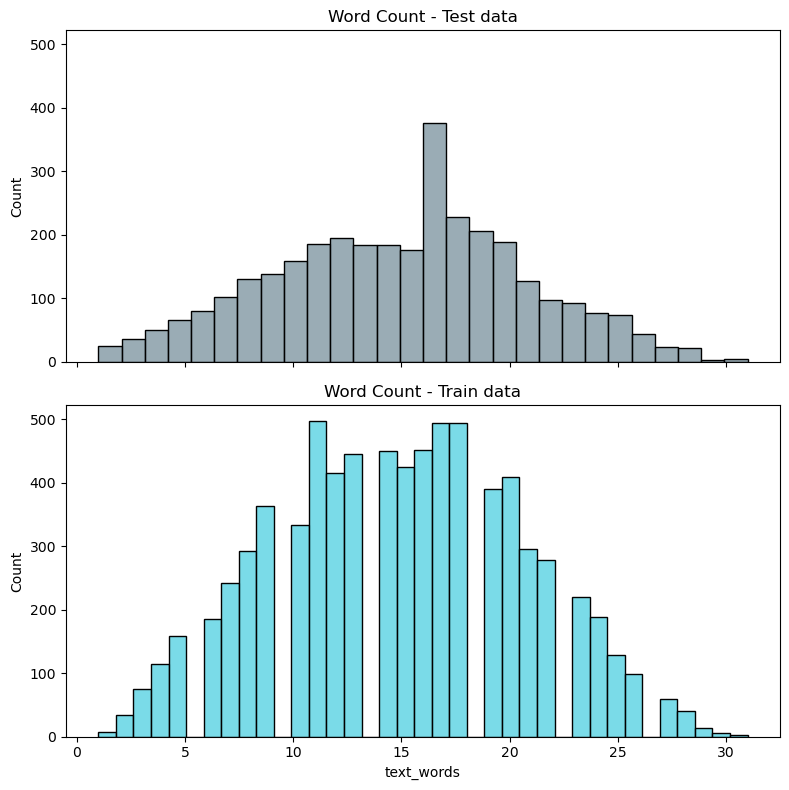

In [22]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8), tight_layout=True, sharex=True, sharey=True)

sns.histplot(data=df_test, x=df_test['text_words'], color='#78909c', ax=axes[0]).set(title='Word Count - Test data')
sns.histplot(data=df_train, x=df_train['text_words'], color='#4dd0e1', ax=axes[1]).set(title='Word Count - Train data');

# Add a Super Title
#fig.suptitle('Distribution of Word Count by Dataset', ha='center')
#plt.savefig("Word_Count_data.png")

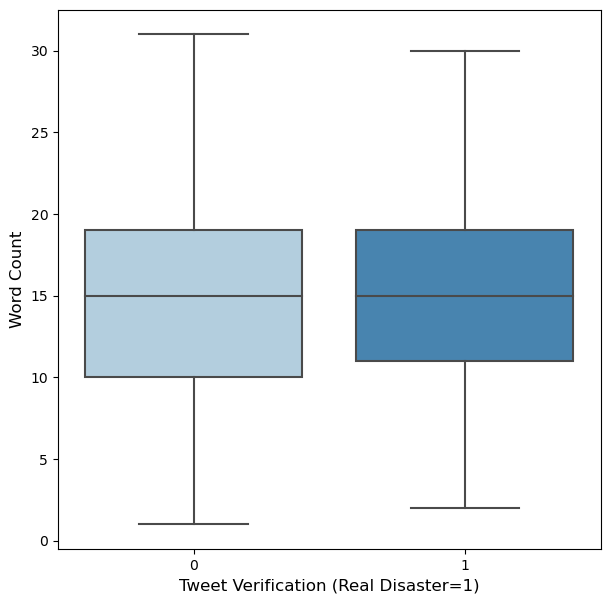

In [23]:
#df_train.boxplot(by ='target', column =['text_words'], grid = False);

plt.figure(figsize=(7,7))
word_count = sns.boxplot(x='target', y='text_words', data=df_train, palette = "Blues")
plt.xlabel('Tweet Verification (Real Disaster=1)', fontsize=12)
plt.ylabel('Word Count', fontsize=12);

Note: the word count for 'real' and 'not real' disasters has a similar distribution, with a slightly shorter word count for 'not real' disasters

In [24]:
#word_count vs character_count
df_train['character_count'] = df_train['text'].str.len()
df_test['character_count'] = df_test['text'].str.len()

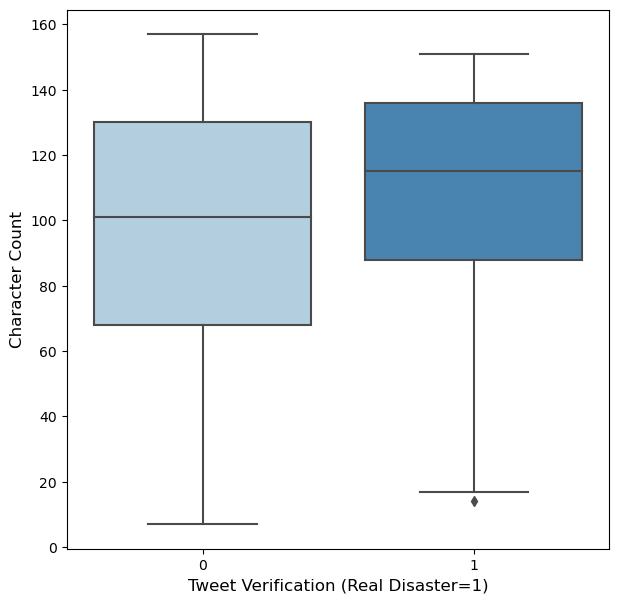

In [25]:
plt.figure(figsize=(7,7))
word_count = sns.boxplot(x='target', y='character_count', data=df_train, palette = "Blues")
plt.xlabel('Tweet Verification (Real Disaster=1)', fontsize=12)
plt.ylabel('Character Count', fontsize=12);

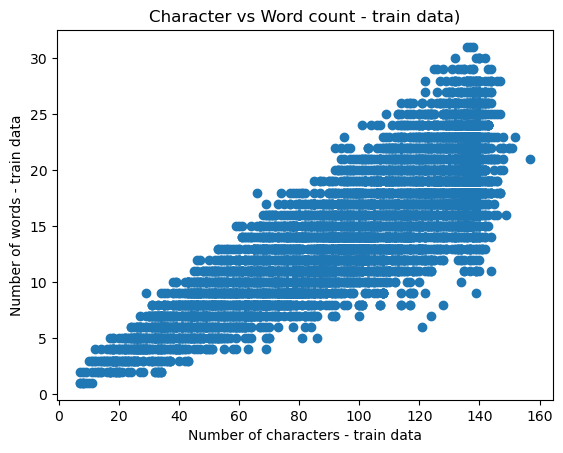

In [26]:
plt.scatter(df_train["character_count"], df_train["text_words"])

plt.xlabel("Number of characters - train data")
plt.ylabel("Number of words - train data")
plt.title("Character vs Word count - train data)")

plt.show()

In [27]:
df_train_target = df_train.groupby(['target']).aggregate({'character_count':'mean','text_words':'mean'})
df_train_target.reset_index()

,target,character_count,text_words
0,0,95.706817,14.704744
1,1,108.113421,15.167533


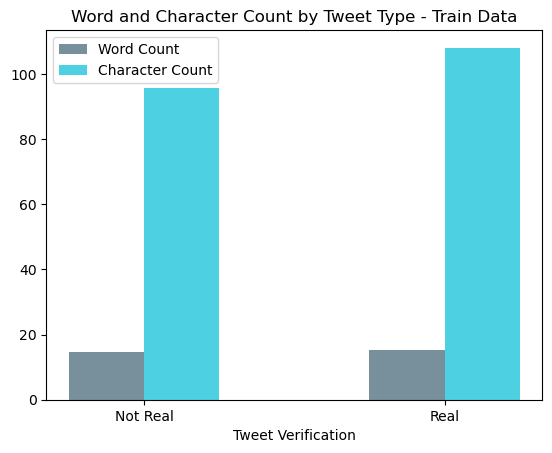

In [28]:
plt.bar(np.arange(2), df_train_target['text_words'], color = '#78909c',
        width = 0.25,
        label='Word Count')
plt.bar(np.arange(2)+.25, df_train_target["character_count"], color = '#4dd0e1',
        width = 0.25,
        label='Character Count')
  
plt.xlabel("Tweet Verification")
plt.title("Word and Character Count by Tweet Type - Train Data")

plt.xticks(np.arange(2)+.25/2,['Not Real', 'Real'])
plt.legend()

  
plt.show()

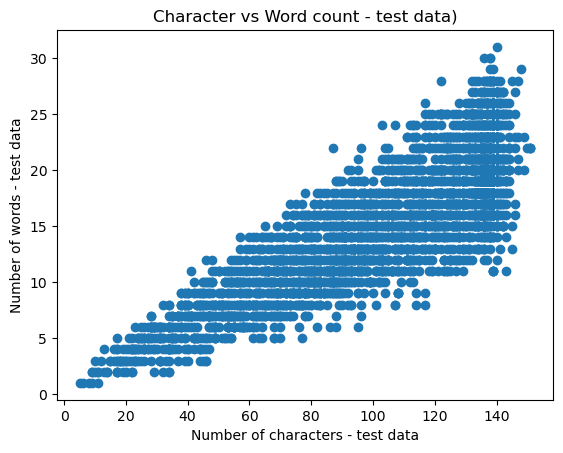

In [29]:
plt.scatter(df_test["character_count"], df_test["text_words"])

plt.xlabel("Number of characters - test data")
plt.ylabel("Number of words - test data")
plt.title("Character vs Word count - test data)")

plt.show()

In [30]:
filtered_df_train = df_train.dropna(subset = ['keyword'])

#df_train['count_keyword'] = df_train.apply(lambda x: x['text'].count(x['keyword']), axis=1)
filtered_df_train['count_keyword'] = [x.text.count(x.keyword) for x in filtered_df_train.itertuples()]

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_42451/1697830117.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_train['count_keyword'] = [x.text.count(x.keyword) for x in filtered_df_train.itertuples()]


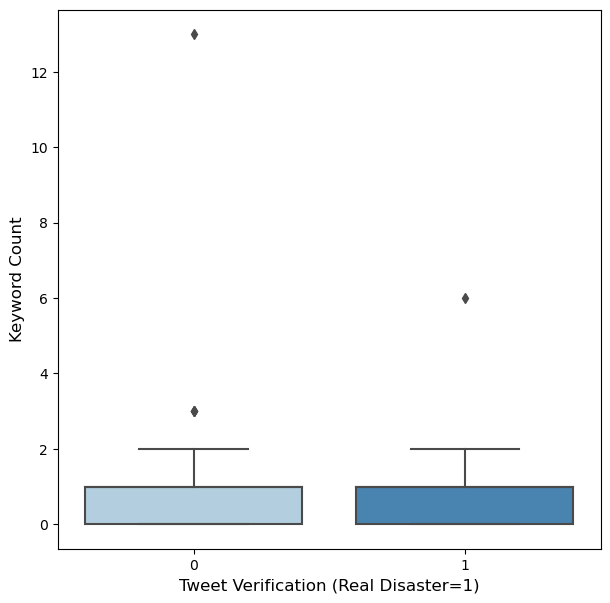

In [31]:
plt.figure(figsize=(7,7))
keyword_count = sns.boxplot(x='target', y='count_keyword', data=filtered_df_train, palette="Blues")
plt.xlabel('Tweet Verification (Real Disaster=1)', fontsize=12)
plt.ylabel('Keyword Count', fontsize=12);

## Data Cleaning

#### Duplicates

While duplicates can signal that an organization explicitly needed to retween a particular tweet, we have duplicates in both real and not real tweets. 

In [36]:
duplicate_rows = df_train.duplicated(subset=['text'])

In [37]:
duplicate_rows.value_counts()

False    7503
True      110
dtype: int64

In [38]:
df_filtered = df_train[df_train.duplicated(subset=['text']) == True]

In [39]:
#df_test_filtered = df_test[df_test.duplicated(subset=['text']) == True]

In [40]:
pd.set_option('display.max_rows', None)

In [41]:
df_train[df_train.duplicated(subset=['text'], keep=False)].groupby("target").count()

,id,keyword,location,text,text_words,character_count
target,,,,,,
0,58,58,30,58,58,58
1,121,116,68,121,121,121


In [42]:
df_train["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [43]:
target_1 = 121/3271
target_1

0.03699174564353409

In [44]:
target_0 = 58/4342
target_0

0.013357899585444496

In [45]:
df_filtered = df_train.drop_duplicates(subset=['text'])

New filtered dataset

In [46]:
df_filtered.shape

(7503, 7)

#### Cleaning Function

In [48]:
def tweet_cleaner(text):
    pattern = r'\b[a-zA-Z]+\b'
    pattern1 = " #abcdefghijklmnopqrstuvwxyz0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    
    emoji_pattern = re.compile("["
                       u"\U0001F600-\U0001F64F"  # emoticons
                       u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                       u"\U0001F680-\U0001F6FF"  # transport & map symbols
                       u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                       u"\U00002702-\U000027B0"
                       u"\U000024C2-\U0001F251"
                       "]+", flags=re.UNICODE)

    # including new stopwords unique to tweets. and adding them to nltk
    stops = nltk.corpus.stopwords.words('english')
    new_stop_words = ["ha", "wa", "http", "s", "https", "com", "'s", "' s", "'ll", "' ll", "' d", "'d", "'re", "' re", "co", "amp", "url"]
    stops.extend(new_stop_words)
    
    text = ''.join(c for c in text if c in pattern1)
    text = re.sub(r'@\S+','',text) # removes usernames
    text = re.sub(r'http://\S+','',text) # removes urls
    text = re.sub(r'https://\S+','',text)
    text = re.sub(r'www.\S+','',text)
    text = emoji_pattern.sub(r'', text)
    
    
    words = [x.lower() for x in text.split() if (x not in stops) and (len(x)>1)]
    sentence = " ".join(words)
    
    return sentence

In [49]:
df_train_copy = df_filtered['text'].apply(lambda txt: tweet_cleaner(txt))

In [50]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    x = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
    return(" ".join(x))

df_train_copy_lemm = df_train_copy.apply(lemmatize_text)

In [51]:
df_filtered_df = pd.DataFrame(df_train_copy_lemm)

#### Data Overview

In [53]:
stops = nltk.corpus.stopwords.words('english')
new_stop_words = ["ha", "wa", "http", "s", "https", "com", "'s", "' s", "'ll", "' ll", "' d", "'d", "'re", "' re", "co", "amp", "url"]
stops.extend(new_stop_words)

In [55]:
cvec_lemm = CountVectorizer(stop_words=stops)
cvec_lemm.fit(df_filtered_df["text"])
cvec_lemm_data = cvec_lemm.transform(df_filtered_df["text"])
df_lemm = pd.DataFrame(cvec_lemm_data.todense(), columns=cvec_lemm.get_feature_names_out())

In [56]:
df_lemm_ = pd.merge(df_lemm, df_filtered["target"], left_index=True, right_index=True)

In [57]:
df_1 = df_train[df_train["target"] == 1]
df_0 = df_train[df_train["target"] == 0]

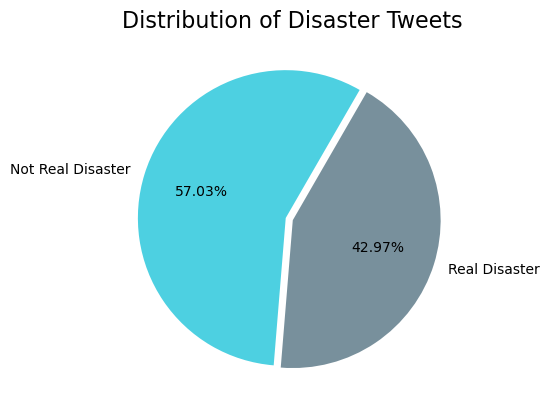

In [59]:
colors = ['#4dd0e1','#78909c']
plt.pie(df_train['target'].value_counts(),
            labels=['Not Real Disaster', 'Real Disaster'],
            autopct='%1.2f%%',
            shadow=False,
            explode=(0.05, 0),
            startangle=60,
            colors=colors);
plt.title(
    label="Distribution of Disaster Tweets", 
    fontdict={"fontsize":16},
);
plt.savefig('../images/tweet_distribution.png')

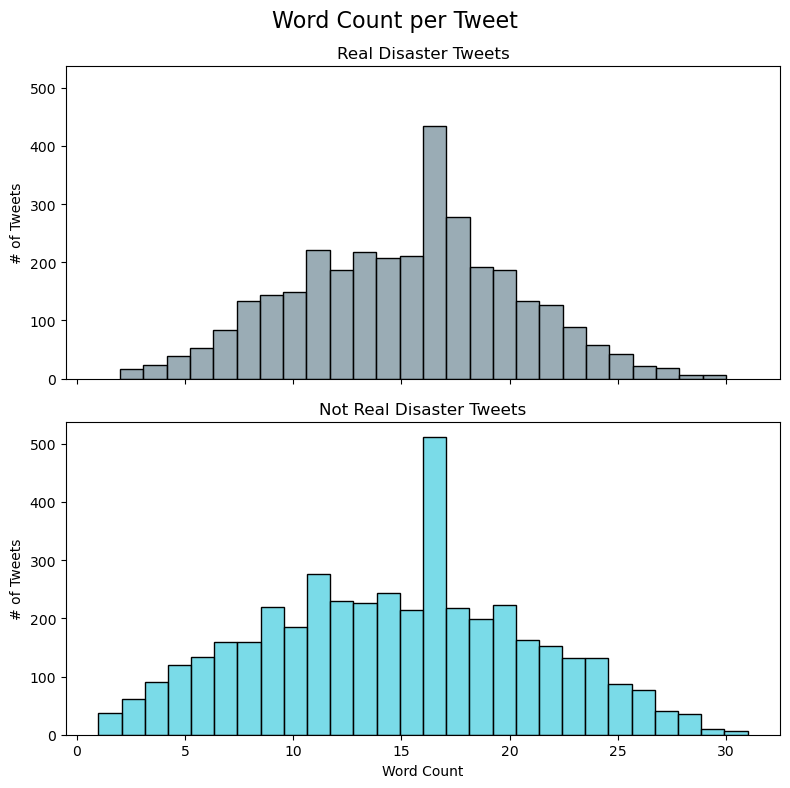

In [60]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8), tight_layout=True, sharex=True, sharey=True)

sns.histplot(data=df_1, x=df_1['text_words'], color='#78909c', ax=axes[0]).set(title='Real Disaster Tweets')
sns.histplot(data=df_0, x=df_0["text_words"], color='#4dd0e1', ax=axes[1]).set(title='Not Real Disaster Tweets')
axes[0].set_xlabel('Word Count')
axes[1].set_xlabel('Word Count')
axes[0].set_ylabel('# of Tweets')
axes[1].set_ylabel('# of Tweets')
fig.suptitle('Word Count per Tweet', fontsize=16);
fig.savefig("../images/word_count.png") 
# Add a Super Title
#fig.suptitle('Distribution of Word Count by Dataset', ha='center')
#plt.savefig("Word_Count_data.png")

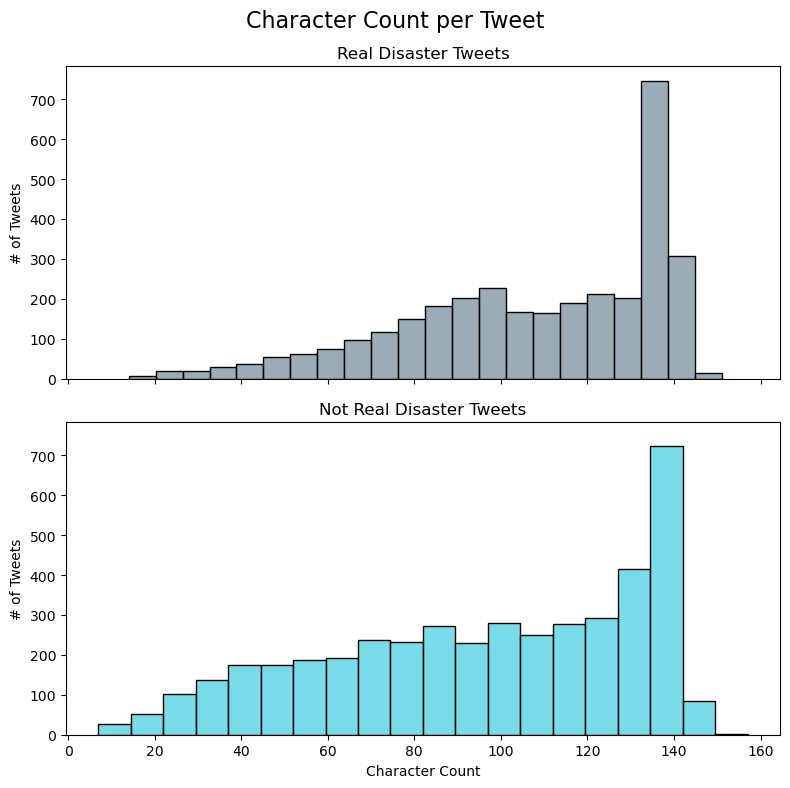

In [61]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8), tight_layout=True, sharex=True, sharey=True)

sns.histplot(data=df_1, x=df_1['character_count'], color='#78909c', ax=axes[0]).set(title='Real Disaster Tweets')
sns.histplot(data=df_0, x=df_0["character_count"], color='#4dd0e1', ax=axes[1]).set(title='Not Real Disaster Tweets')
axes[0].set_xlabel('Character Count')
axes[1].set_xlabel('Character Count')
axes[0].set_ylabel('# of Tweets')
axes[1].set_ylabel('# of Tweets')
fig.suptitle('Character Count per Tweet', fontsize=16);
fig.savefig("../images/character_count.png") 
# Add a Super Title
#fig.suptitle('Distribution of Word Count by Dataset', ha='center')
#plt.savefig("Word_Count_data.png")

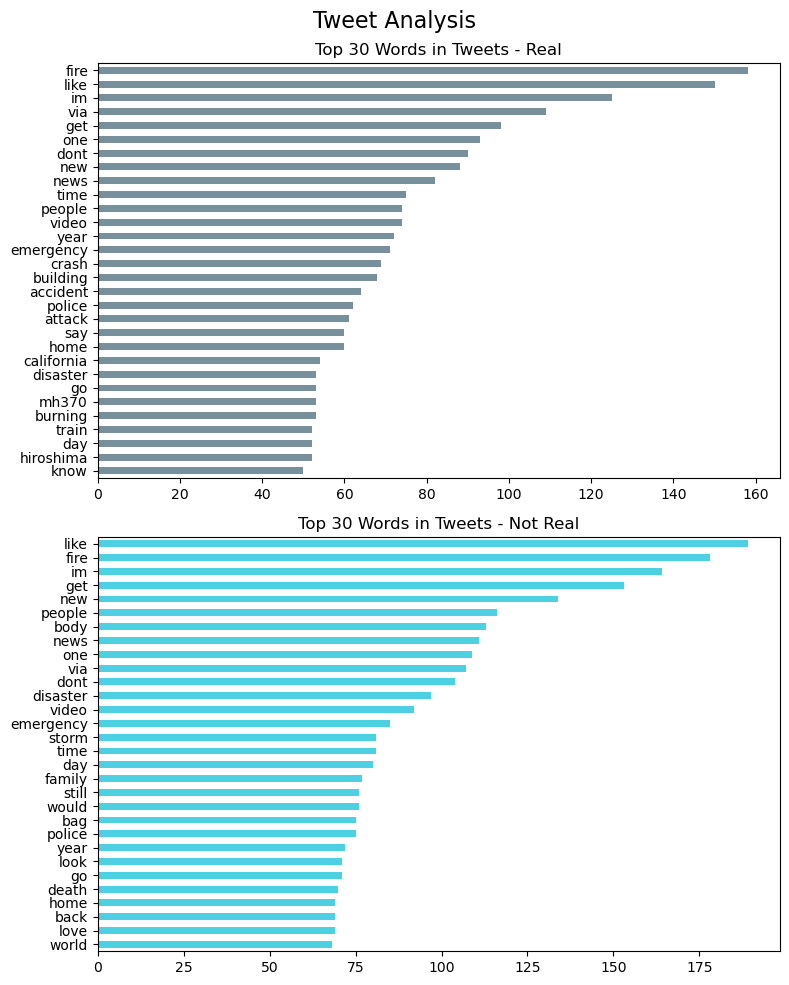

In [62]:
fig, axes = plt.subplots(2, 1, figsize=(8, 10), tight_layout=True)

(df_lemm_[df_lemm_['target_y'] == 1]
    .drop(columns=['target_y'])
    .sum()
    .sort_values(ascending=False)
    .head(30)
    .plot(kind='barh', title='Top 30 Words in Tweets - Real', color='#78909c', ax=axes[0])).invert_yaxis();

(df_lemm_[df_lemm_['target_y'] == 0]
    .drop(columns=['target_y'])
    .sum()
    .sort_values(ascending=False)
    .head(30)
    .plot(kind='barh', title='Top 30 Words in Tweets - Not Real', color='#4dd0e1', ax=axes[1])).invert_yaxis(); 

fig.suptitle('Tweet Analysis', fontsize=16);
plt.savefig('../images/Unigrams.png')

In [64]:
cvec_lemm_2 = CountVectorizer(ngram_range=(2, 2),stop_words=stops)
cvec_lemm_2.fit(df_filtered_df["text"])
cvec_lemm_data_2 = cvec_lemm_2.transform(df_filtered_df["text"])
df_lemm_2 = pd.DataFrame(cvec_lemm_data_2.todense(), columns=cvec_lemm_2.get_feature_names_out())

In [65]:
df_lemm_2_ = pd.merge(df_lemm_2, df_filtered["target"], left_index=True, right_index=True)

In [66]:
cvec_lemm_3 = CountVectorizer(ngram_range=(3, 3),stop_words=stops)
cvec_lemm_3.fit(df_filtered_df["text"])
cvec_lemm_data_3 = cvec_lemm_3.transform(df_filtered_df["text"])
df_lemm_3 = pd.DataFrame(cvec_lemm_data_3.todense(), columns=cvec_lemm_3.get_feature_names_out())

In [67]:
df_lemm_3_ = pd.merge(df_lemm_3, df_filtered["target"], left_index=True, right_index=True)

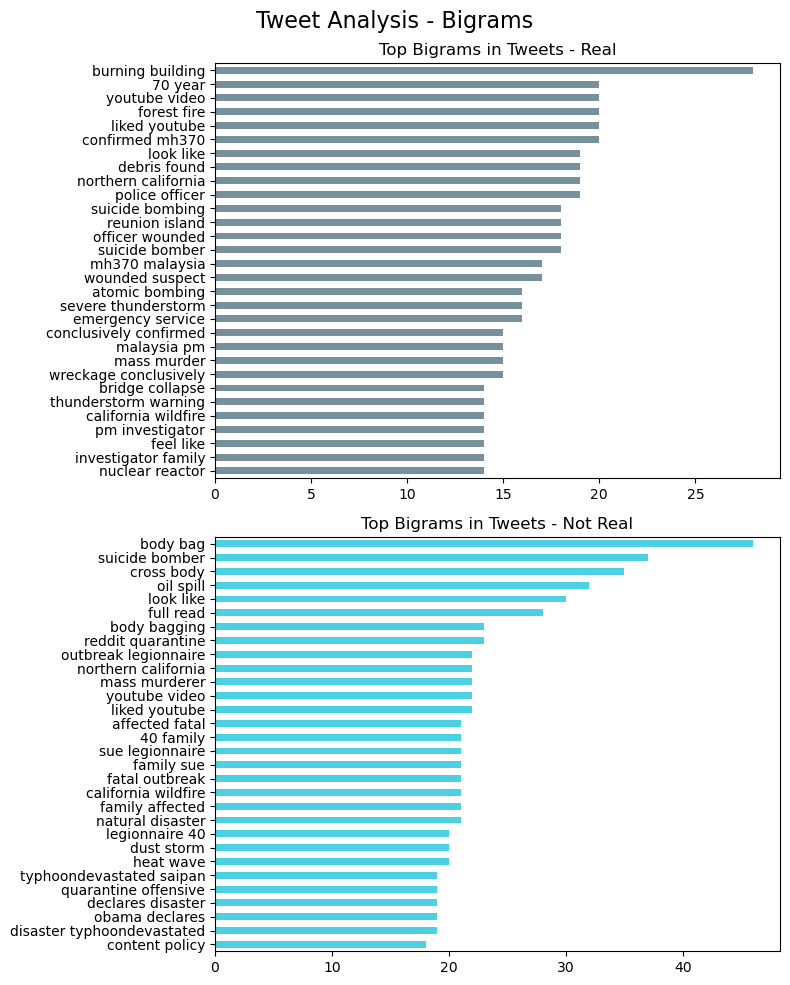

In [68]:
fig, axes = plt.subplots(2, 1, figsize=(8, 10), tight_layout=True)

(df_lemm_2_[df_lemm_2_['target'] == 1]
    .drop(columns=['target'])
    .sum()
    .sort_values(ascending=False)
    .head(30)
    .plot(kind='barh', title='Top Bigrams in Tweets - Real', color='#78909c', ax=axes[0])).invert_yaxis();


(df_lemm_2_[df_lemm_2_['target'] == 0]
    .drop(columns=['target'])
    .sum()
    .sort_values(ascending=False)
    .head(30)
    .plot(kind='barh', title='Top Bigrams in Tweets - Not Real', color='#4dd0e1', ax=axes[1])).invert_yaxis();

fig.suptitle('Tweet Analysis - Bigrams', fontsize=16);
plt.savefig('../images/Bigrams.png')

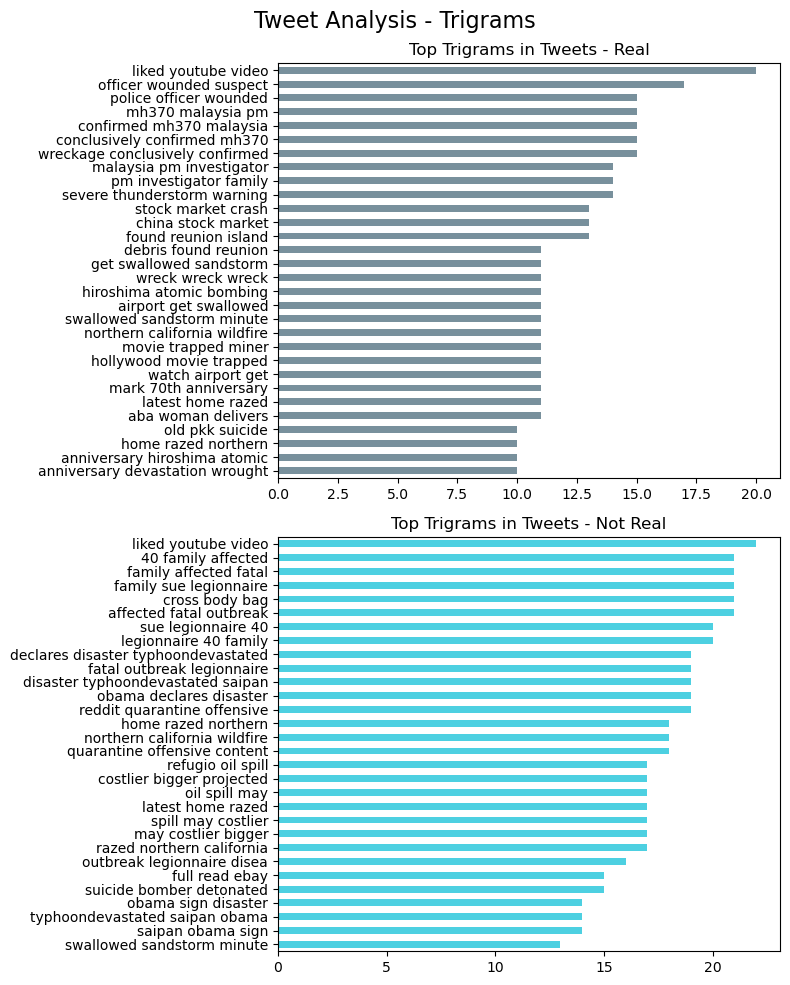

In [69]:
fig, axes = plt.subplots(2, 1, figsize=(8, 10), tight_layout=True)

(df_lemm_3_[df_lemm_3_['target'] == 1]
    .drop(columns=['target'])
    .sum()
    .sort_values(ascending=False)
    .head(30)
    .plot(kind='barh', title='Top Trigrams in Tweets - Real', color='#78909c', ax=axes[0])).invert_yaxis();


(df_lemm_3_[df_lemm_3_['target'] == 0]
    .drop(columns=['target'])
    .sum()
    .sort_values(ascending=False)
    .head(30)
    .plot(kind='barh', title='Top Trigrams in Tweets - Not Real', color='#4dd0e1', ax=axes[1])).invert_yaxis();

fig.suptitle('Tweet Analysis - Trigrams', fontsize=16);
plt.savefig('../images/Trigrams.png')

## Data Findings

In [73]:
# use of hashtags
df_filtered["hashtags"] = list(map(lambda x: x.count("#"), df_filtered['text']))

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_42451/432856284.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["hashtags"] = list(map(lambda x: x.count("#"), df_filtered['text']))


#### Number of Hashtags

In [74]:
symbol00 = df_filtered.groupby("target")["hashtags"].aggregate(["sum", "mean"]).reset_index()

In [76]:
symbol00

,target,sum,mean
0,0,1659,0.385366
1,1,1653,0.516886


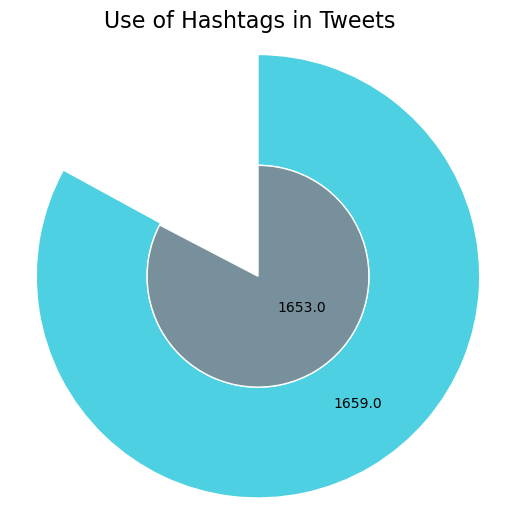

In [151]:
from matplotlib import cm
from math import log10

labels = ["Not Real Disaster", "Real Disaster"]
data = symbol00["sum"]
#number of data points
n = len(data)
#find max value for full ring
k = 10 ** int(log10(max(data)))
m = k * (1 + max(data) // k)

#radius of donut chart
r = 1.5
#calculate width of each ring
w = r / n 

#create colors along a chosen colormap
colors = ['#4dd0e1','#78909c']
labels = ["{:.1f}".format(i) for i in symbol00["sum"]]


#create figure, axis
fig, ax = plt.subplots()
ax.axis("equal")

#create rings of donut chart
for i in range(n):
    #hide labels in segments with textprops: alpha = 0 - transparent, alpha = 1 - visible
    innerring, _ = ax.pie([m - data[i], data[i]], radius = r - i * w, startangle = 90, labels = ["", labels[i]], labeldistance = 1 - 1 / (1.5 * (n - i)), textprops = {"alpha": 1}, colors = ["white", colors[i]])
    plt.setp(innerring, width = w, edgecolor = "white")
fig.suptitle('Use of Hashtags in Tweets', fontsize=16, y=1.05)
plt.savefig('../images/Hashtags.jpg')
plt.show()


In [77]:
# nu. URLs
df_filtered["urls"] = list(sum(y.count(x) for x in ("www","http","https")) for y in df_filtered['text'])


/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_42451/2384385366.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["urls"] = list(sum(y.count(x) for x in ("www","http","https")) for y in df_filtered['text'])


#### Number of URLs

In [79]:
symbol0 = df_filtered.groupby("target")["urls"].aggregate(["sum", "mean"]).reset_index()
symbol0

,target,sum,mean
0,0,2475,0.574913
1,1,2629,0.822076


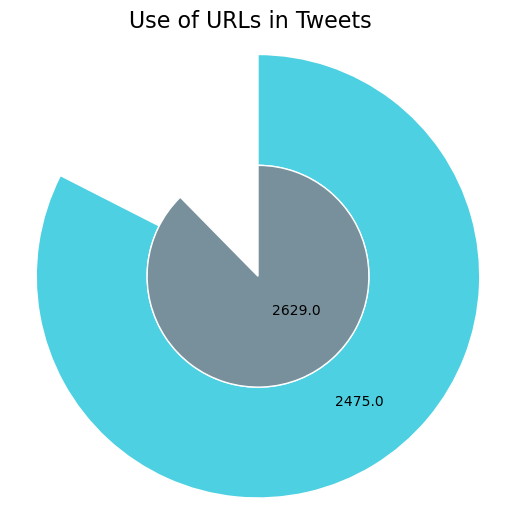

In [152]:
from matplotlib import cm
from math import log10

labels = ["Not Real Disaster", "Real Disaster"]
data = symbol0["sum"]
#number of data points
n = len(data)
#find max value for full ring
k = 10 ** int(log10(max(data)))
m = k * (1 + max(data) // k)

#radius of donut chart
r = 1.5
#calculate width of each ring
w = r / n 

#create colors along a chosen colormap
colors = ['#4dd0e1','#78909c']
labels = ["{:.1f}".format(i) for i in symbol0["sum"]]


#create figure, axis
fig, ax = plt.subplots()
ax.axis("equal")

#create rings of donut chart
for i in range(n):
    #hide labels in segments with textprops: alpha = 0 - transparent, alpha = 1 - visible
    innerring, _ = ax.pie([m - data[i], data[i]], radius = r - i * w, startangle = 90, labels = ["", labels[i]], labeldistance = 1 - 1 / (1.5 * (n - i)), textprops = {"alpha": 1}, colors = ["white", colors[i]])
    plt.setp(innerring, width = w, edgecolor = "white")
fig.suptitle('Use of URLs in Tweets', fontsize=16, y=1.05)
plt.savefig('../images/URLs.png')
plt.show()


In [82]:
# use of @
df_filtered["@"] = list(map(lambda x: x.count("@"), df_filtered['text']))

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_42451/365825439.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["@"] = list(map(lambda x: x.count("@"), df_filtered['text']))


#### Number of User References "@"

In [83]:
symbol1 = df_filtered.groupby("target")["@"].aggregate(["sum", "mean"]).reset_index()
symbol1

,target,sum,mean
0,0,1846,0.428804
1,1,894,0.279550


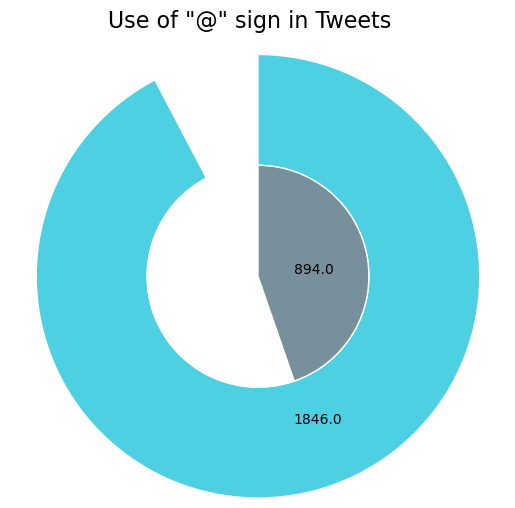

In [153]:
from matplotlib import cm
from math import log10

labels = ["Not Real Disaster", "Real Disaster"]
data = symbol1["sum"]
#number of data points
n = len(data)
#find max value for full ring
k = 10 ** int(log10(max(data)))
m = k * (1 + max(data) // k)

#radius of donut chart
r = 1.5
#calculate width of each ring
w = r / n 

#create colors along a chosen colormap
colors = ['#4dd0e1','#78909c']
labels = ["{:.1f}".format(i) for i in symbol1["sum"]]


#create figure, axis
fig, ax = plt.subplots()
ax.axis("equal")

#create rings of donut chart
for i in range(n):
    #hide labels in segments with textprops: alpha = 0 - transparent, alpha = 1 - visible
    innerring, _ = ax.pie([m - data[i], data[i]], radius = r - i * w, startangle = 90, labels = ["", labels[i]], labeldistance = 1 - 1 / (1.5 * (n - i)), textprops = {"alpha": 1}, colors = ["white", colors[i]])
    plt.setp(innerring, width = w, edgecolor = "white")
fig.suptitle('Use of "@" sign in Tweets', fontsize=16, y=1.05)
plt.savefig('../images/Users.png')
plt.show()


#### Number of Duplicates

In [85]:
# duplicates
symbol2 = df_train[df_train.duplicated(subset=['text'], keep=False)].groupby("target").count().reset_index()

In [86]:
symbol2

,target,id,keyword,location,text,text_words,character_count
0,0,58,58,30,58,58,58
1,1,121,116,68,121,121,121


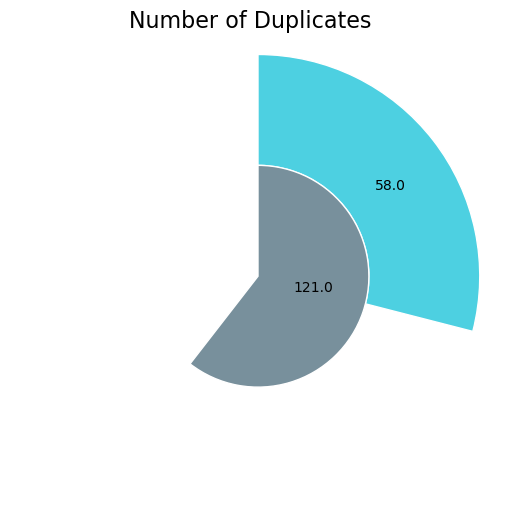

In [154]:
from matplotlib import cm
from math import log10

labels = ["Not Real Disaster", "Real Disaster"]
data = symbol2["id"]
#number of data points
n = len(data)
#find max value for full ring
k = 10 ** int(log10(max(data)))
m = k * (1 + max(data) // k)

#radius of donut chart
r = 1.5
#calculate width of each ring
w = r / n 

#create colors along a chosen colormap
colors = ['#4dd0e1','#78909c']
labels = ["{:.1f}".format(i) for i in symbol2["id"]]


#create figure, axis
fig, ax = plt.subplots()
ax.axis("equal")

#create rings of donut chart
for i in range(n):
    #hide labels in segments with textprops: alpha = 0 - transparent, alpha = 1 - visible
    innerring, _ = ax.pie([m - data[i], data[i]], radius = r - i * w, startangle = 90, labels = ["", labels[i]], labeldistance = 1 - 1 / (1.5 * (n - i)), textprops = {"alpha": 1}, colors = ["white", colors[i]])
    plt.setp(innerring, width = w, edgecolor = "white")
fig.suptitle('Number of Duplicates', fontsize=16, y=1.05)
plt.savefig('../images/Duplicates.png')
plt.show()


In [88]:
symbol3 = df_filtered[df_filtered.duplicated(subset=['text'], keep=False)].groupby("target").count()
df_filtered[df_filtered.duplicated(subset=['text']) == True]

,id,keyword,location,text,target,text_words,character_count,hashtags,urls,@


## Modeling 

#### Bernoulli

**Count Vector**

In [90]:
X_lemm = df_filtered_df["text"]
y = df_filtered["target"]

In [91]:
df_test_copy = df_test['text'].apply(lambda txt: tweet_cleaner(txt))

In [92]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    x = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
    return(" ".join(x))

df_test_copy_lemm = df_test_copy.apply(lemmatize_text)

In [93]:
df_test_df = pd.DataFrame(df_test_copy_lemm)

In [94]:
X_lemm_test = df_test_df["text"]

In [95]:
X_lemm.to_csv('X.csv')
y.to_csv('y.csv')

In [96]:
Xn_train, Xn_traintest, y_train, y_traintest = train_test_split(X_lemm,
                                                    y,
                                                    random_state=42, stratify=y)

In [97]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('bnb', BernoulliNB())
])

In [98]:
pipe_params = {
    'cvec__max_features' : [5000],
    'cvec__min_df' : [2,5],
    'cvec__max_df' : [0.9, 0.95],
    'cvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'cvec__stop_words' : ['english'],
}

In [99]:
gs_n = GridSearchCV(pipe, 
                  pipe_params, 
                  cv = 5)

In [100]:
gs_n.fit(Xn_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('bnb', BernoulliNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000], 'cvec__min_df': [2, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': ['english']})

In [101]:
gs_n.best_score_

0.7924258140911783

In [102]:
print(gs_n.score(Xn_train,y_train))
print(gs_n.score(Xn_traintest,y_traintest))

0.838279722765239
0.8166311300639659


In [103]:
from sklearn.metrics import classification_report

In [104]:
print(classification_report(y_train, gs_n.predict(Xn_train))) 

              precision    recall  f1-score   support

           0       0.81      0.93      0.87      3229
           1       0.89      0.71      0.79      2398

    accuracy                           0.84      5627
   macro avg       0.85      0.82      0.83      5627
weighted avg       0.84      0.84      0.83      5627



In [105]:
print(classification_report(y_traintest, gs_n.predict(Xn_traintest))) 

              precision    recall  f1-score   support

           0       0.79      0.92      0.85      1076
           1       0.86      0.68      0.76       800

    accuracy                           0.82      1876
   macro avg       0.83      0.80      0.81      1876
weighted avg       0.82      0.82      0.81      1876



In [106]:
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [107]:
def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(pipe, pipe_params, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(Xn_train, y_train)

    # make the predictions
    y_pred = grid_search.predict(Xn_traintest)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_traintest, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [108]:
grid_search_gs_n = grid_search_wrapper(refit_score='precision_score')

Best params for precision_score
{'cvec__max_df': 0.9, 'cvec__max_features': 5000, 'cvec__min_df': 2, 'cvec__ngram_range': (2, 2), 'cvec__stop_words': 'english'}

Confusion matrix of Random Forest optimized for precision_score on the test data:
     pred_neg  pred_pos
neg      1061        15
pos       503       297


In [109]:
results = pd.DataFrame(grid_search_gs_n.cv_results_)
results = results.sort_values(by='mean_test_precision_score', ascending=False)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__max_df,param_cvec__max_features,param_cvec__min_df,param_cvec__ngram_range,param_cvec__stop_words,params,...,split2_train_accuracy_score,split3_train_accuracy_score,split4_train_accuracy_score,split5_train_accuracy_score,split6_train_accuracy_score,split7_train_accuracy_score,split8_train_accuracy_score,split9_train_accuracy_score,mean_train_accuracy_score,std_train_accuracy_score
2,0.137078,0.017465,0.013610,0.005403,0.9,5000,2,"(2, 2)",english,"{'cvec__max_df': 0.9, 'cvec__max_features': 50...",...,0.744866,0.744076,0.743483,0.748025,0.748025,0.746496,0.745903,0.746101,0.745414,0.001680
8,0.123940,0.014338,0.011114,0.004493,0.95,5000,2,"(2, 2)",english,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",...,0.744866,0.744076,0.743483,0.748025,0.748025,0.746496,0.745903,0.746101,0.745414,0.001680
5,0.148542,0.038537,0.015280,0.008802,0.9,5000,5,"(2, 2)",english,"{'cvec__max_df': 0.9, 'cvec__max_features': 50...",...,0.688191,0.687006,0.688586,0.691746,0.692733,0.688450,0.687660,0.686871,0.688407,0.002215
11,0.126184,0.017022,0.010070,0.002402,0.95,5000,5,"(2, 2)",english,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",...,0.688191,0.687006,0.688586,0.691746,0.692733,0.688450,0.687660,0.686871,0.688407,0.002215
1,0.365818,0.094178,0.020639,0.008330,0.9,5000,2,"(1, 2)",english,"{'cvec__max_df': 0.9, 'cvec__max_features': 50...",...,0.839455,0.838665,0.834321,0.839850,0.838863,0.835341,0.838697,0.839684,0.837944,0.001781


**TFIDF**

In [110]:
pipe_params_tvec = {
    'tvec__max_features' : [5000],
    'tvec__min_df' : [2,5],
    'tvec__max_df' : [0.9, 0.95],
    'tvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'tvec__stop_words' : ['english']
}

In [111]:
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('bnb', BernoulliNB())
])

In [112]:
gs_n_tvec = GridSearchCV(pipe_tvec, 
                  pipe_params_tvec, 
                  cv = 5)

In [113]:
gs_n_tvec.fit(Xn_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('bnb', BernoulliNB())]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [5000], 'tvec__min_df': [2, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': ['english']})

In [114]:
gs_n_tvec.best_score_

0.7924258140911783

In [115]:
print(gs_n_tvec.score(Xn_train,y_train))
print(gs_n_tvec.score(Xn_traintest,y_traintest))

0.838279722765239
0.8166311300639659


#### Logistic Regression

**Count Vector**

In [116]:
pipe_logr = Pipeline([
    ('cvec', CountVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear'))
])

In [117]:
gs_n_logr = GridSearchCV(pipe_logr, 
                  pipe_params, 
                  cv = 5)

In [118]:
gs_n_logr.fit(Xn_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000], 'cvec__min_df': [2, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': ['english']})

In [119]:
gs_n_logr.best_score_

0.7961591474245115

In [120]:
print(gs_n_logr.score(Xn_train,y_train))
print(gs_n_logr.score(Xn_traintest,y_traintest))

0.8937266749600142
0.8150319829424307


**TFIDF**

In [121]:
pipe_tvec_logr = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear'))
])

In [122]:
gs_n_tvec_logr = GridSearchCV(pipe_tvec_logr, 
                pipe_params_tvec, 
                  cv = 5)

In [123]:
gs_n_tvec_logr.fit(Xn_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [5000], 'tvec__min_df': [2, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': ['english']})

In [124]:
gs_n_tvec_logr.best_score_

0.7931388198144859

In [125]:
print(gs_n_tvec_logr.score(Xn_train,y_train))
print(gs_n_tvec_logr.score(Xn_traintest,y_traintest))

0.9114981339968011
0.8043710021321961


#### ADA Boost + Logistic Regression

In [126]:
abc = AdaBoostClassifier(random_state = 42)

In [127]:
cv = CountVectorizer(min_df=2)
cv.fit(Xn_train)

Xn_train_cv = cv.transform(Xn_train)
Xn_test_cv = cv.transform(Xn_traintest)

In [128]:
dt_abc_n = abc.fit(Xn_train_cv, y_train)

In [129]:
print(dt_abc_n.score(Xn_train_cv, y_train))
print(dt_abc_n.score(Xn_test_cv, y_traintest))

0.7670161720277234
0.744136460554371


#### Decision Tree

In [130]:
dtc = DecisionTreeClassifier()

In [131]:
dt_n = dtc.fit(Xn_train_cv, y_train)

In [132]:
print(dt_n.score(Xn_train_cv, y_train))
print(dt_n.score(Xn_test_cv, y_traintest))

0.9882708370357206
0.7452025586353944


In [133]:
tv = TfidfVectorizer(min_df=2)
tv.fit(Xn_train)

Xn_train_tv = tv.transform(Xn_train)
Xn_test_tv = tv.transform(Xn_traintest)

In [134]:
dt_n_tvec = dtc.fit(Xn_train_tv, y_train)

In [135]:
print(dt_n_tvec.score(Xn_train_tv, y_train))
print(dt_n_tvec.score(Xn_test_tv, y_traintest))

0.9880931224453527
0.7345415778251599


#### Random Forest

In [136]:
rf = RandomForestClassifier()

In [137]:
rf_params = {
    'n_estimators' : [100, 150, 200],
    'max_depth': [None, 3, 4, 5, 6, 7]
}
gs_dt_n = GridSearchCV(rf, param_grid=rf_params, cv=5, n_jobs=-1)
gs_dt_n.fit(Xn_train_cv, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 3, 4, 5, 6, 7],
                         'n_estimators': [100, 150, 200]})

In [138]:
print(gs_dt_n.score(Xn_train_cv,y_train))
print(gs_dt_n.score(Xn_test_cv,y_traintest))

0.9882708370357206
0.7846481876332623


In [139]:
rf_params = {
    'n_estimators' : [100, 150, 200],
    'max_depth': [None, 3, 4, 5, 6, 7]
}
gs_dt_tvec_n = GridSearchCV(rf, param_grid=rf_params, cv=5, n_jobs=-1)
gs_dt_tvec_n.fit(Xn_train_tv, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 3, 4, 5, 6, 7],
                         'n_estimators': [100, 150, 200]})

In [140]:
print(gs_dt_tvec_n.score(Xn_train_tv,y_train))
print(gs_dt_tvec_n.score(Xn_test_tv,y_traintest))

0.9880931224453527
0.7963752665245203


## Final evaluation

TN: 840
FP: 236
FN: 161
TP: 639
Sensitivity: 0.79875
Specificity: 0.7806691449814126
Validation Accuracy: 0.7883795309168443


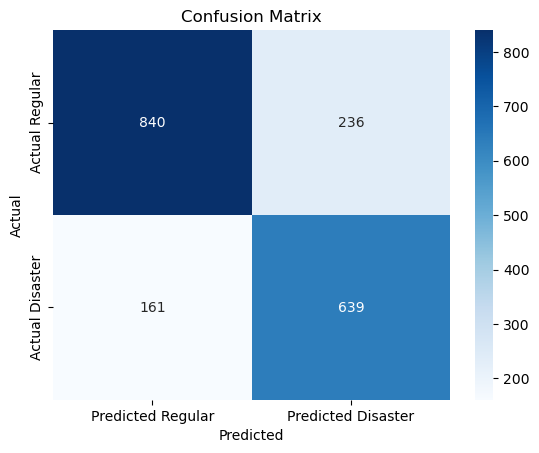

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_42451/2872825482.py:29: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')


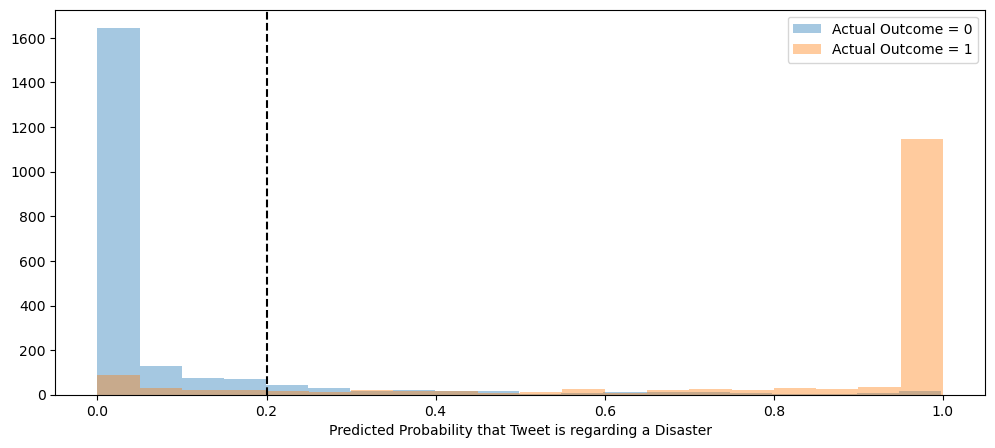

In [156]:
def sklearn_evaluation(model, X_test_in_model, y_test_truth, decision_boundary=0.2):

    predict_probs = model.predict_proba(X_test_in_model)[:,1]

    preds = (predict_probs > decision_boundary).astype(int)

    conf_matrix = confusion_matrix(y_test_truth, preds)

    tn, fp, fn, tp = conf_matrix.ravel()

    print(f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}")

    print(f"Sensitivity: {tp/(tp+fn)}\nSpecificity: {tn/(tn + fp)}\nValidation Accuracy: {(tp+tn)/(tp+tn+fp+fn)}")

    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Regular', 'Predicted Disaster'], yticklabels=['Actual Regular', 'Actual Disaster'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig('../images/Polina_Confusion.png')
    plt.show();

    reshaped_probs=predict_probs.tolist()
    
    pred_df = pd.DataFrame({'true_values': y_test_truth, 'pred_probs': predict_probs})

    plt.figure(figsize = (12, 5))
    # plot distributions of predicted probabilities by actual values
    for group in pred_df.groupby('true_values'):
        sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')
    
    # Add cutoff line
    plt.axvline(decision_boundary, color = 'black', linestyle = '--')

    plt.xlabel('Predicted Probability that Tweet is regarding a Disaster')
    plt.legend();
    plt.savefig('../images/Polina_Prob_Graph.png')

sklearn_evaluation(gs_n, Xn_traintest, y_traintest)

## Submission

In [ ]:
predictions = gs_n.predict(X_lemm_test)

In [145]:
import pickle

In [147]:
with open('../pickles/X_test.pkl', 'wb') as f:
    pickle.dump(X_lemm_test, f)

In [ ]:
predictions_test = gs_n.predict(X_test_test)

In [ ]:
submission_test = pd.DataFrame({'id':df_test.id, 'target':predictions_test})

In [ ]:
submission_test["target"].value_counts()

In [ ]:
submission_ = submission_test.to_csv('submission.csv', index=False)

In [ ]:
submission = pd.DataFrame({'id':df_test.id, 'target':predictions})

In [ ]:
submission["target"].value_counts()

In [ ]:
submission__ = submission.to_csv('submission_cleaned.csv', index=False)

##They sky was ablaze tonight in Los Angeles. I'm expecting IG and FB to be filled with sunset shots if I know my peeps!! Pickle and Use

In [148]:
with open('../pickles/Polina_Model.pkl', 'wb') as f:
    pickle.dump(gs_n, f)

In [ ]:
with open('Polina_Model.pkl', 'rb') as f:
    model = pickle.load(f)

In [ ]:
from nltk.stem import PorterStemmer

In [ ]:
def tweet_cleaner(text, stemmer = PorterStemmer()):
    pattern = r'\b[a-zA-Z]+\b'
    pattern1 = " #abcdefghijklmnopqrstuvwxyz0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    
    emoji_pattern = re.compile("["
                       u"\U0001F600-\U0001F64F"  # emoticons
                       u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                       u"\U0001F680-\U0001F6FF"  # transport & map symbols
                       u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                       u"\U00002702-\U000027B0"
                       u"\U000024C2-\U0001F251"
                       "]+", flags=re.UNICODE)

    # including new stopwords unique to tweets. and adding them to nltk
    stops = nltk.corpus.stopwords.words('english')
    new_stop_words = ["ha", "wa", "http", "s", "https", "com", "'s", "' s", "'ll", "' ll", "' d", "'d", "'re", "' re", "co", "amp", "url"]
    stops.extend(new_stop_words)
    
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = WordNetLemmatizer()
    
    text = ''.join(c for c in text if c in pattern1)
    text = re.sub(r'@\S+','',text) # removes usernames
    text = re.sub(r'http://\S+','',text) # removes urls
    text = re.sub(r'https://\S+','',text)
    text = re.sub(r'www.\S+','',text)
    text = emoji_pattern.sub(r'', text)
    
    
    words = [x.lower() for x in text.split() if (x not in stops) and (len(x)>1)]
    sentence = " ".join(words)
    splits = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(sentence)]
    list_of_sentences = " ".join(splits)
    
    return list_of_sentences #list_of_words, list_of_stems, list_of_sentences, labels


In [ ]:
text = "ðŸ™ðŸ»ðŸŒˆðŸ™ðŸ How the West was burned: Thousands of wildfires ablaze in #California alone \\n http://t.co/iCSjGZ9tE1 #climate #energy http://t.co/9FxmN0l0B"

In [ ]:
tweet_cleaner(text)

In [ ]:
text_c = input('Enter a disaster tweet here to check whether it\'s real or not: ')

text = tweet_cleaner(text_c)


prediction = model.predict([text])[0]


if prediction > 0.8:
  print(f"This disaster notification is: REAL.{prediction} Please stay safe!")
elif prediction > 0.5:
  print(f"This disaster notification might be: REAL.{prediction} Please work with your local news channel to learn more.")
else:
  print(f"This tweet is: NOT REAL.{prediction} Please enjoy your day!")

In [ ]:
p = model.predict_proba([text])
p